# Chaper 2 - N-armed Bandits
### Deep Reinforcement Learning _in Action_

##### Listing 2.1

In [26]:
def get_best_action(actions):
	best_action = 0
	max_action_value = 0
	for i in range(len(actions)): #A 
		cur_action_value = get_action_value(actions[i]) #B
		if cur_action_value > max_action_value:
			best_action = i
			max_action_value = cur_action_value
	return best_action

##### Listing 2.2

In [2]:
import numpy as np
from scipy import stats
import random
import matplotlib.pyplot as plt

n = 10
probs = np.random.rand(n) #A
eps = 0.1

##### Listing 2.3

In [3]:
def get_reward(prob, n=10):
    reward = 0;
    for i in range(n):
        if random.random() < prob:
            reward += 1
    return reward

In [4]:
reward_test = [get_reward(0.7) for _ in range(2000)]

In [5]:
np.mean(reward_test)

6.9985

In [6]:
sum = 0
x = [4,5,6,7]
for j in range(len(x)): 
	sum = sum + x[j]
sum

22

(array([  1.,  15.,  63., 222., 393., 556., 466., 230.,  54.]),
 array([ 2.        ,  2.88888889,  3.77777778,  4.66666667,  5.55555556,
         6.44444444,  7.33333333,  8.22222222,  9.11111111, 10.        ]),
 <BarContainer object of 9 artists>)

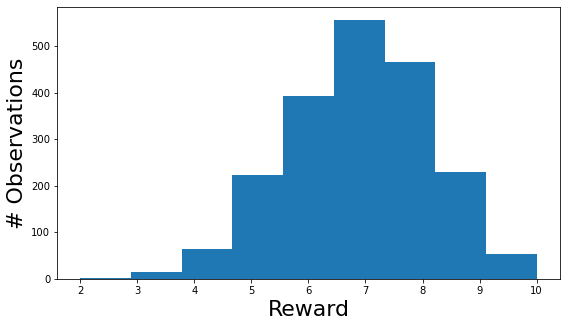

In [7]:
plt.figure(figsize=(9,5))
plt.xlabel("Reward",fontsize=22)
plt.ylabel("# Observations",fontsize=22)
plt.hist(reward_test,bins=9)

##### Listing 2.4

In [8]:
# 10 actions x 2 columns
# Columns: Count #, Avg Reward
record = np.zeros((n,2))

In [9]:
def get_best_arm(record):
    arm_index = np.argmax(record[:,1],axis=0)
    return arm_index

In [10]:
def update_record(record,action,r):
    new_r = (record[action,0] * record[action,1] + r) / (record[action,0] + 1)
    record[action,0] += 1
    record[action,1] = new_r
    return record

##### Listing 2.5

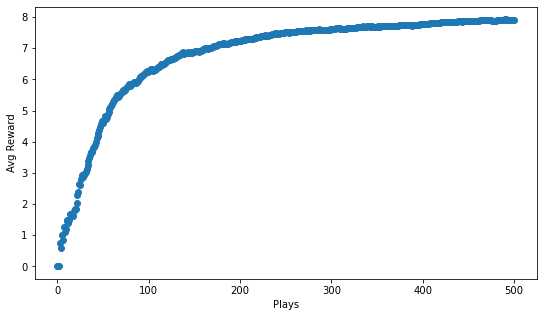

In [11]:
fig,ax = plt.subplots(1,1)
ax.set_xlabel("Plays")
ax.set_ylabel("Avg Reward")
fig.set_size_inches(9,5)
rewards = [0]
for i in range(500):
    if random.random() > 0.2:
        choice = get_best_arm(record)
    else:
        choice = np.random.randint(10)
    r = get_reward(probs[choice])
    record = update_record(record,choice,r)
    mean_reward = ((i+1) * rewards[-1] + r)/(i+2)
    rewards.append(mean_reward)
ax.scatter(np.arange(len(rewards)),rewards)

##### Listing 2.6

In [12]:
def softmax(av, tau=1.12):
    softm = ( np.exp(av / tau) / np.sum( np.exp(av / tau) ) )
    return softm

In [13]:
probs = np.random.rand(n)
record = np.zeros((n,2))

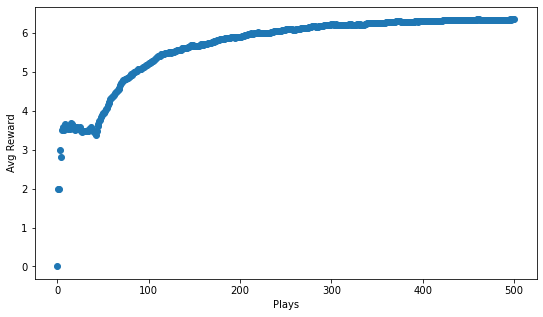

In [14]:
fig,ax = plt.subplots(1,1)
ax.set_xlabel("Plays")
ax.set_ylabel("Avg Reward")
fig.set_size_inches(9,5)
rewards = [0]
for i in range(500):
    p = softmax(record[:,1],tau=0.7)
    choice = np.random.choice(np.arange(n),p=p)
    r = get_reward(probs[choice])
    record = update_record(record,choice,r)
    mean_reward = ((i+1) * rewards[-1] + r)/(i+2)
    rewards.append(mean_reward)
ax.scatter(np.arange(len(rewards)),rewards)

##### Listing 2.9

In [15]:
class ContextBandit:
    def __init__(self, arms=10):
        self.arms = arms
        self.init_distribution(arms)
        self.update_state()
        
    def init_distribution(self, arms):
        # Num states = Num Arms to keep things simple
        self.bandit_matrix = np.random.rand(arms,arms)
        #each row represents a state, each column an arm
        
    def reward(self, prob):
        reward = 0
        for i in range(self.arms):
            if random.random() < prob:
                reward += 1
        return reward
        
    def get_state(self):
        return self.state
    
    def update_state(self):
        self.state = np.random.randint(0,self.arms)
        
    def get_reward(self,arm):
        return self.reward(self.bandit_matrix[self.get_state()][arm])
        
    def choose_arm(self, arm):
        reward = self.get_reward(arm)
        self.update_state()
        return reward

In [16]:
import numpy as np
import torch

arms = 10
N, D_in, H, D_out = 1, arms, 100, arms

In [17]:
env = ContextBandit(arms=10)
state = env.get_state()
reward = env.choose_arm(1)
print(state)

9


In [18]:
model = torch.nn.Sequential(
    torch.nn.Linear(D_in, H),
    torch.nn.ReLU(),
    torch.nn.Linear(H, D_out),
    torch.nn.ReLU(),
)

In [19]:
loss_fn = torch.nn.MSELoss()

In [20]:
env = ContextBandit(arms)

In [21]:
def one_hot(N, pos, val=1):
    one_hot_vec = np.zeros(N)
    one_hot_vec[pos] = val
    return one_hot_vec

In [22]:
def running_mean(x,N=50):
    c = x.shape[0] - N
    y = np.zeros(c)
    conv = np.ones(N)
    for i in range(c):
        y[i] = (x[i:i+N] @ conv)/N
    return y

In [23]:
def train(env, epochs=5000, learning_rate=1e-2):
    cur_state = torch.Tensor(one_hot(arms,env.get_state())) #A
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    rewards = []
    for i in range(epochs):
        y_pred = model(cur_state) #B
        av_softmax = softmax(y_pred.data.numpy(), tau=2.0) #C
        av_softmax /= av_softmax.sum() #D
        choice = np.random.choice(arms, p=av_softmax) #E
        cur_reward = env.choose_arm(choice) #F
        one_hot_reward = y_pred.data.numpy().copy() #G
        one_hot_reward[choice] = cur_reward #H
        reward = torch.Tensor(one_hot_reward)
        rewards.append(cur_reward)
        loss = loss_fn(y_pred, reward)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        cur_state = torch.Tensor(one_hot(arms,env.get_state())) #I
    return np.array(rewards)

In [24]:
rewards = train(env)

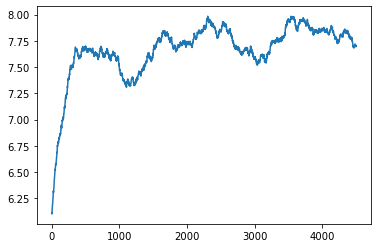

In [25]:
plt.plot(running_mean(rewards,N=500))